# Prototype pipeline for the analysis of ML arxiv data

We query arxiv to get papers, and then run them against Crossref event data to find social media discussion and Microsoft Academic Knowledge to find institutional affiliations

```
Query Arxiv -> Paper repository -> Analysis -> Topic model -> Classify
                        |               |
                        |               |----> Social network analysis of researchers
                        |               |----> Geocoding of institutions (via GRID?)
                        |
                Extract author data from Google Scholar ----> Geocode institution via Google Places API?
                        |                                                   |
                Enrich paper data with MAK(?)                               |---> Spatial and network analysis
                        |
                Obtain Crossref Event data
                
```


# Preamble

In [2]:
%matplotlib inline

#Some imports
import time
#import xml.etree.ElementTree as etree
from lxml import etree
import feedparser

#Imports
#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Figures
fig_path = os.path.join(top,'reports')

#Models
mod_path = os.path.join(top,'models')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])


In [2]:
#Functions

# 1. Get Arxiv data about machine learning

* Write a APi querier and extract papers with the terms machine learning or artificial intelligence. Get 2000 results... and play nice!


In [3]:
class Arxiv_querier():
    '''
    This class takes as an input a query and the number of results, and returns all the parsed results.
    Includes routines to deal with multiple pages of results.

    '''
    
    def __init__(self,base_url="http://export.arxiv.org/api/query?"):
        '''
        Initialise
        '''
        
        self.base_url = base_url
    
    def query(self,query_string,max_results=100,wait_time=3):
        '''
        Query the base url
        
        '''
        #Attribute query string
        
        #Load base URL
        base_url = self.base_url
        
        #Prepare query string
        processed_query = re.sub(' ','+',query_string)
        
        self.query_string="_".join(query_string.split(" "))
        
        start=0
        pages = 0
        
        #Run the query and store results for as long as the number of results is bigger than the max results
        keep_running = True
        
        result_store = []
        
        while keep_running==True:
            pages +=1
            print(pages)
            
            #Query url (NB the start arg, which will change as we go through different
            #pages)
            query_url = base_url+'search_query=all:{q}&start={s}&max_results={max_res}'.format(
                q=processed_query,s=start,max_res=max_results)
            
        
            #Download
            source = requests.get(query_url)
            
            #Parse the xml and get the entries (papers)
            parsed = feedparser.parse(source.content)
            
            #Extract entries
            entries = parsed['entries']
            
            #If the number of entries is bigger than the maximum number of results
            #this means we need to go to another page. We do that by offseting the
            #start with max results
            
            result_store.append(entries)
            
            if len(entries)==max_results:
                start+=max_results
            
            #If we have less than max results this means we have run out of 
            #results and we toggle the keep_running switch off.
            if len(entries)<max_results:
                keep_running=False
                
            time.sleep(wait_time)
        
        #Save results in a flat list
        self.entry_results = [x for el in result_store for x in el]
        
    def extract_data(self):
        '''
        Here we extract data from the entries 
        
        '''
        
        #Load entries
        entries = self.entry_results
        
        #Create df
        output = pd.concat([pd.DataFrame({
            'query':self.query_string,
            'id':x['id'],
            'link':x['link'],
            'title':x['title'],
            'authors':", ".join([el['name'] for el in x['authors']]),
            'summary':x['summary'],
            'updated':x['updated'],
            'published':x['published'],
            'category':x['arxiv_primary_category']['term'],
            'pdf':str([el['href'] for el in x['links']  if el['type']=='application/pdf'][0]
                     )},index=[0]) for x in entries]).reset_index(drop=True)
        
        output['year_published'] = [x.split("-")[0] for x in output['published']]
        
        self.output_df = output

In [216]:
query_terms = ['artificial intelligence','machine learning','deep learning']


#There are some inconsistencies in the number of results so we run the query three times for each
#term and remove duplicated results

def extract_arxiv_data(term,max_results=1000,wait_time=10, tests=3):
    '''
    This function initialises the Arxiv_querier class, extracts the data and outputs it
    
    '''
    print(term)
    
    collected = []
    
    #We collect the data thrice
    for i in np.arange(tests):
        print('run'+ ' ' +str(i))
        initialised = Arxiv_querier()
        initialised.query(term,max_results,wait_time)
        initialised.extract_data()
        out = initialised.output_df
        collected.append(out)
        
    #We concatenate the dfs and remove the duplicates.
    
    output = pd.concat(collected)
    output_no_dupes = output.drop_duplicates('id')
    
    #Return both
    return([output,output_no_dupes])


arxiv_ai_results_three = [extract_arxiv_data(term=q) for q in query_terms]

artificial intelligence
run 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
run 1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
run 2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
machine learning
run 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
run 1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
run 2
1
2
3
4
5
6
7
8
deep learning
run 0
1
2
3
4
5
6
7
run 1
1
2
run 2
1


In [373]:
all_papers = pd.concat([x[1] for x in arxiv_ai_results_three]).drop_duplicates('id').reset_index(drop=True)
print(all_papers.shape)
all_papers.head()

(38999, 11)


,authors,category,id,link,pdf,published,query,summary,title,updated,year_published
0,Tshilidzi Marwala,q-fin.GN,http://arxiv.org/abs/1509.01213v1,http://arxiv.org/abs/1509.01213v1,http://arxiv.org/pdf/1509.01213v1,2015-07-01T16:26:21Z,artificial_intelligence,Artificial intelligence has impacted many aspe...,Impact of Artificial Intelligence on Economic ...,2015-07-01T16:26:21Z,2015
1,"Dan Geiger, Prakash Shenoy",cs.AI,http://arxiv.org/abs/1304.3846v1,http://arxiv.org/abs/1304.3846v1,http://arxiv.org/pdf/1304.3846v1,2013-04-13T20:44:25Z,artificial_intelligence,This is the Proceedings of the Thirteenth Conf...,Proceedings of the Thirteenth Conference on Un...,2013-04-13T20:44:25Z,2013
2,"David Heckerman, E. Mamdani",cs.AI,http://arxiv.org/abs/1304.3851v1,http://arxiv.org/abs/1304.3851v1,http://arxiv.org/pdf/1304.3851v1,2013-04-13T21:03:12Z,artificial_intelligence,This is the Proceedings of the Ninth Conferenc...,Proceedings of the Ninth Conference on Uncerta...,2013-04-13T21:03:12Z,2013
3,"Laveen Kanal, John Lemmer",cs.AI,http://arxiv.org/abs/1304.3859v1,http://arxiv.org/abs/1304.3859v1,http://arxiv.org/pdf/1304.3859v1,2013-04-13T21:37:12Z,artificial_intelligence,This is the Proceedings of the Second Conferen...,Proceedings of the Second Conference on Uncert...,2013-04-13T21:37:12Z,2013
4,Michael Swan Laufer,cs.AI,http://arxiv.org/abs/1311.0716v1,http://arxiv.org/abs/1311.0716v1,http://arxiv.org/pdf/1311.0716v1,2013-10-30T14:19:49Z,artificial_intelligence,"In this paper, I put forward that in many inst...",Artificial Intelligence in Humans,2013-10-30T14:19:49Z,2013


In [374]:
all_papers.to_csv(int_data+'/{today}_ai_papers.csv'.format(today=today_str),index=False)

# 2. Some exploratory analysis

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, PunktSentenceTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
import scipy
import ast
import string as st
from bs4 import BeautifulSoup

import gensim
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import product

stopwords_c =  stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer= WordNetLemmatizer()

/usr/local/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [7]:
#Read papers
all_papers = pd.read_csv(int_data+'/19_8_2017_ai_papers.csv'.format(today=today_str))

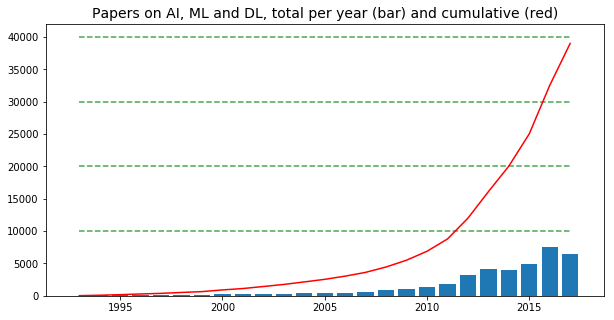

In [8]:
#Let's begin by looking at years

#When where they published?

#Year distribution
year_pubs = all_papers['year_published'].value_counts()
year_pubs.index = [int(x) for x in year_pubs.index]

fig,ax = plt.subplots(figsize=(10,5))

year_pubs_sorted = year_pubs[sorted(year_pubs.index)]
year_pubs_subset = year_pubs_sorted[year_pubs_sorted.index>1991]

ax.plot(np.arange(1993,2018),year_pubs_subset.cumsum(),color='red')
ax.bar(np.arange(1993,2018),year_pubs_subset)
ax.hlines(xmin=1993,xmax=2017,y=[10000,20000,30000,40000],colors='green',linestyles='dashed',alpha=0.7)


ax.set_title("Papers on AI, ML and DL, total per year (bar) and cumulative (red)",size=14)


In [9]:
#What are the categories of the papers? Are we capturing what we think we are capturing
#Top 20
all_papers['category'].value_counts()[:20]

cs.AI                6983
cs.LG                5043
stat.ML              4799
cs.CV                3216
cs.CL                1466
cs.NE                 952
cs.IT                 613
stat.ME               586
quant-ph              578
astro-ph              562
math.OC               550
math.ST               492
cond-mat.mes-hall     489
cs.RO                 485
cs.IR                 450
cs.SI                 435
cs.LO                 413
astro-ph.IM           391
cs.NI                 362
cs.CY                 338
Name: category, dtype: int64

See <a href='https://arxiv.org/help/api/user-manual'>here</a> for abbreviations of categories.

In a nutshell, AI is AI, LG is 'Learning', CV is 'Computer Vision', 'CL' is 'computation and language' and NE is 'Neural and Evolutionary computing'. SL.ML is kind of self-explanatory. We seem to be picking up the main things

In [10]:
#NB do we want to remove hyphens?
punct = re.sub('-','',st.punctuation)

In [11]:
def comp_sentence(sentence):
    '''
    Takes a sentence and pre-processes it.
    The output is the sentence as a bag of words
    
    '''
    #Remove line breaks and hyphens
    sentence = re.sub('\n',' ',sentence)
    sentence = re.sub('-',' ',sentence)
    
    #Lowercase and tokenise
    text_lowered = [x.lower() for x in sentence.split(" ")]
    
    #Remove signs and digits
    text_no_signs_digits = ["".join([x for x in el if x not in punct+st.digits]) for 
                            el in text_lowered]
        
    #Remove stop words, single letters
    text_stopped = [w for w in text_no_signs_digits if w not in stopwords_c and
                   len(w)>1]
    
    #Stem
    text_lemmatised = [lemmatizer.lemmatize(w) for w in text_stopped]
    
    #Output
    return(text_lemmatised)

In [90]:
#Process text
clean_corpus = [comp_sentence(x) for x in all_papers['summary']]

In [91]:
#We remove rate words
word_freqs = pd.Series([x for el in clean_corpus for x in el]).value_counts()

word_freqs[:30]

model          38373
data           28715
method         28506
algorithm      27870
learning       26955
problem        24803
network        23526
based          21769
system         18944
approach       18448
result         17895
paper          17894
show           17434
using          16476
time           13776
two            12595
set            12269
also           11862
new            11756
feature        11753
state          11549
used           11492
proposed       11445
function       11360
one            11321
information    11137
performance    11013
machine        10880
present        10670
task           10076
dtype: int64

In [92]:
rare_words = word_freqs.index[word_freqs<=2]
rare_words[:10]

Index(['certifiable', 'bake', 'aeraulic', 'spdvcfp', 'sobre', 'stitched',
       'undithering', 'bookkeeping', 'recycle', 'lssol'],
      dtype='object')

Lots of the rare words seem to be typos and so forth. We remove them

In [93]:
#Removing rare words
clean_corpus_no_rare = [[x for x in el if x not in rare_words] for el in clean_corpus]

## 2 NLP (topic modelling & word embeddings)

In [94]:
#Identify 2-grams (frequent in science!)
bigram_transformer = gensim.models.Phrases(clean_corpus_no_rare)

#Train the model on the corpus

#Let's do a bit of grid search

#model = gensim.models.Word2Vec(bigram_transformer[clean_corpus], size=360, window=15, min_count=2, iter=20)

In [472]:
model.most_similar('ai_safety')

[('cybersecurity', 0.5190048813819885),
 ('ethic', 0.5039341449737549),
 ('ai', 0.5019052624702454),
 ('ethical_issue', 0.496062695980072),
 ('agi', 0.48768138885498047),
 ('astrobiology', 0.4816303849220276),
 ('technological_advance', 0.48043808341026306),
 ('deception', 0.4778890013694763),
 ('appreciation', 0.474555104970932),
 ('ethical', 0.4712696373462677)]

In [470]:
model.most_similar('complexity')

[('computational_complexity', 0.5796849727630615),
 ('treewidth', 0.4251006245613098),
 ('ulbc', 0.3759896457195282),
 ('qrd', 0.37181398272514343),
 ('communication_cost', 0.36393606662750244),
 ('tree_width', 0.3622165024280548),
 ('worst_case', 0.35874366760253906),
 ('running_time', 0.35821208357810974),
 ('computational_cost', 0.3545072078704834),
 ('polynomial', 0.3506772816181183)]

In [475]:
model.most_similar('github')

[('open_source', 0.7268495559692383),
 ('source_code', 0.7222407460212708),
 ('python', 0.705554723739624),
 ('released', 0.671886682510376),
 ('repository', 0.6573259830474854),
 ('downloaded', 0.6564698219299316),
 ('freely_available', 0.6537964344024658),
 ('download', 0.653651237487793),
 ('open_sourced', 0.6528508067131042),
 ('made_publicly', 0.6449865102767944)]

In [96]:
#Create 3 different dictionaries and bows depending on word sizes

def remove_words_below_threshold(corpus,threshold):
    '''
    Takes a list of terms and removes any which are below a threshold of occurrences
    
    '''
    #Produce token frequencies
    token_frequencies = pd.Series([x for el in corpus for x in el]).value_counts()
    
    #Identify tokens to drop (below a threshold)
    tokens_to_drop = token_frequencies.index[token_frequencies<=threshold]
    
    #Processed corpus
    processed_corpus = [[x for x in el if x not in tokens_to_drop] for el in corpus]
    
    #Dictionary
    dictionary = gensim.corpora.Dictionary(processed_corpus)
    corpus_bow = [dictionary.doc2bow(x) for x in processed_corpus]
    
    return([dictionary,corpus_bow,processed_corpus])

In [97]:
#Initial model run to see what comes out.

#Transform corpus to bigrams
transformed_corpus = bigram_transformer[clean_corpus]

corpora_to_process = {str(x):remove_words_below_threshold(transformed_corpus,x) for x in [1,2,5,10]}

/usr/local/lib/python3.5/site-packages/gensim/models/phrases.py:248: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [534]:
#Need to turn this into a function.
#Topic modelling

#Parameters for Grid search.
lda_params = list(product([100,200,300],[2,5]))

#Model container
lda_models = []

for x in lda_params:
    #Print stage
    print('{x}_{y}'.format(x=x[0],y=x[1]))
    
    #Load corpus and dict
    
    dictionary = corpora_to_process[str(x[1])][0]
    corpus_bow = corpora_to_process[str(x[1])][1]
    corpus = corpora_to_process[str(x[1])][2]
    
    print('training')
    #Train model
    mod = gensim.models.LdaModel(corpus_bow,num_topics=x[0],id2word=dictionary,
                                 passes=10,iterations=50)
    
    print('coherence')
    #Extract coherence
    cm = CoherenceModel(mod,texts=corpus,
                             dictionary=dictionary,coherence='u_mass')
    
    #Get value
    try:
        coherence_value = cm.get_coherence()
    except:
        print('coherence_error')
        coherence_value='error'
    
    
    lda_models.append([x,mod,[coherence_value,cm]])

100_2
training
coherence
100_5
training
coherence
200_2
training
coherence
200_5
training
coherence
300_2
training
coherence
300_5
training
coherence


In [535]:
with open(mod_path+'/{t}_ai_topic_models.p'.format(t=today_str),'wb') as outfile:
    pickle.dump(lda_models,outfile)

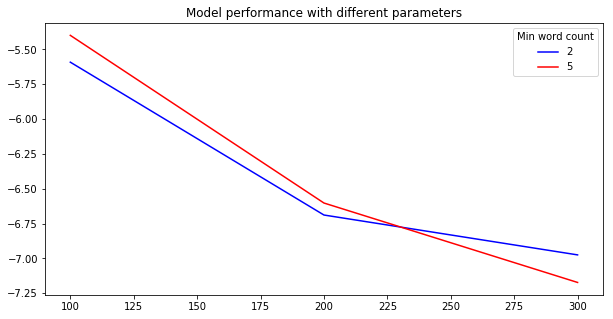

In [536]:
#Visualiase model performance

model_eval = pd.DataFrame([[x[0][0],x[0][1],x[2][0]] for x in lda_models],columns=['topics','word_lim','coherence'])

fig,ax = plt.subplots(figsize=(10,5))

cols = ['red','green','blue']
legs = []

for num,x in enumerate(set(model_eval['word_lim'])):
    
    subset = model_eval.loc[[z == x  for z in model_eval['word_lim']],:]
    
    ax.plot(subset.loc[:,'topics'],subset.loc[:,'coherence'],color=cols[num-1])
    
    legs.append([cols[num-1],x]) 

ax.legend(labels=[x[1] for x in legs],title='Min word count')
ax.set_title('Model performance with different parameters')

In [15]:
with open(mod_path+'/19_8_2017_ai_topic_models.p','rb') as infile:
    lda_models = pickle.load(infile)

In [100]:
check_model= lda_models[1][1]

#Explore topics via LDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(
    #Insert best model/corpus/topics here    
    check_model, 
    corpora_to_process[str(5)][1],
    corpora_to_process[str(5)][0])

/usr/local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
57     5.419409        1       1 -0.225916 -0.123433
9      4.232364        1       2 -0.263194  0.099681
5      3.437799        1       3 -0.227036 -0.018125
42     3.061537        1       4 -0.157977 -0.119175
18     2.873507        1       5 -0.131508 -0.113078
13     2.391134        1       6 -0.296213 -0.018157
73     2.361188        1       7 -0.063001 -0.016846
40     2.144255        1       8 -0.087338 -0.120354
99     1.974000        1       9 -0.181934  0.042342
46     1.844330        1      10  0.070611  0.043023
41     1.833557        1      11 -0.265785 -0.061197
54     1.702595        1      12  0.020565  0.055031
67     1.426047        1      13 -0.268788 -0.095871
70     1.333841        1      14 -0.076057  0.012479
91     1.286647        1      15 -0.031419 -0.103794
56     1.251398        1      16 -0.200825  0.189125
98     1.213052        1      17 -0.171551  0.053520
21     1.204298        1      18 -0.015183 -0.085161
64     1.189790        1      19 -0.254854 -0.106588
15     1.154577        1      20 -0.098571 -0.049710
36     1.134779        1      21 -0.236785  0.076950
62     1.133391        1      22 -0.092988  0.156009
61     1.109935        1      23  0.075456 -0.013181
12     1.089505        1      24 -0.151512  0.095938
81     1.085638        1      25 -0.169000  0.195092
55     1.026907        1      26 -0.042567 -0.157955
20     1.009117        1      27  0.084602 -0.030518
37     1.006234        1      28  0.069181  0.005695
87     1.004119        1      29  0.066171  0.021986
10     0.961697        1      30  0.016595 -0.056606
...         ...      ...     ...       ...       ...
59     0.621650        1      71  0.072462  0.020894
63     0.617379        1      72  0.073947 -0.018010
22     0.602663        1      73  0.095199  0.024136
7      0.601415        1      74  0.081566 -0.037070
32     0.594665        1      75  0.105633  0.013422
17     0.590822        1      76  0.073865 -0.020691
34     0.589498        1      77  0.089203  0.048090
89     0.579089        1      78  0.100897  0.005771
69     0.574985        1      79  0.097867  0.045831
94     0.568627        1      80  0.100071  0.001992
49     0.562043        1      81  0.078735 -0.060240
58     0.561302        1      82  0.096802 -0.007927
25     0.547226        1      83  0.061313 -0.004066
33     0.544455        1      84  0.089689 -0.024055
88     0.532335        1      85  0.013223 -0.033567
96     0.525940        1      86  0.092876 -0.005805
14     0.524782        1      87  0.113231  0.006488
84     0.486804        1      88  0.078345  0.026652
30     0.454526        1      89  0.093417  0.041953
71     0.449260        1      90  0.085412 -0.007730
78     0.448688        1      91  0.085361  0.030713
8      0.442412        1      92  0.115548  0.010375
52     0.437397        1      93  0.092537  0.046841
79     0.434545        1      94  0.091790 -0.030886
75     0.418577        1      95  0.106265  0.004918
74     0.417252        1      96  0.118586  0.011142
2      0.409716        1      97  0.061522  0.068070
48     0.392069        1      98  0.083636  0.001688
43     0.368782        1      99  0.010547  0.056894
50     0.314575        1     100  0.121422  0.008994

[100 rows x 5 columns], topic_info=       Category          Freq                    Term         Total  loglift  \
term                                                                           
26957   Default  14303.000000                    none  14303.000000  30.0000   
3677    Default  11475.000000              simulation  11475.000000  29.0000   
23790   Default  22826.000000               potential  22826.000000  28.0000   
22152   Default   9216.000000                 pay_per   9216.000000  27.0000   
13557   Default  14031.000000               algorithm  14031.000000  26.0000   
26730   Default   8429.000000     

In [17]:
#Can we extract the relevant terms for the topics as in Sievert and Shirley in order to name them?

#First - create a matrix with top 30 terms per topic
top_30_kws = [check_model.get_topic_terms(topicid=n,topn=1000) for n in np.arange(0,100)]

#Keyword df where the columns are tokens and the rows are topics
top_30_kws_df = pd.concat([pd.DataFrame([x[1] for x in el],
                                        index=[x[0] for x in el]) for el in top_30_kws],
                          axis=1).fillna(0).T.reset_index(drop=True)

In [98]:
#This is the dictionary
selected_dictionary = corpora_to_process[str(5)][0]

#Total number of terms in the document
total_terms = np.sum([vals for vals in selected_dictionary.dfs.values()])

#Appearances of different terms
document_freqs = pd.Series([v for v in selected_dictionary.dfs.values()],
                           index=[k for k in selected_dictionary.dfs.keys()])[top_30_kws_df.columns]/total_terms

#Normalise the terms (divide the vector of probabilities of each keywords in each topic by the totals)
top_30_kws_normalised = top_30_kws_df.apply(lambda x: x/document_freqs,axis=0)

In [ ]:
#Now we want to extract, for each topic, the relevance score.

def relevance_score(prob_in_topic,prob_in_corpus,id2word_lookup,lambda_par = 0.6):
    '''
    Combines the probabilities using the definition in Sievert and Shirley and returns the top 5 named
    #terms for each topic    
    '''
    #Create dataframe
    combined = pd.concat([prob_in_topic,prob_in_corpus],axis=1)
    
    combined.columns=['prob_in_topic','prob_in_corpus']
    
    #Create relevance metric
    combined['relevance'] = lambda_par*combined['prob_in_topic'] + (1-lambda_par)*combined['prob_in_corpus']
    
    #Top words
    top_ids = list(combined.sort_values('relevance',ascending=False).index[:5])
    
    #Top words
    top_words = "_".join([id2word_lookup[this_id] for this_id in top_ids])
    
    return(top_words)


In [ ]:
relevance_scores = [relevance_score(top_30_kws_df.iloc[n,:],
                                   top_30_kws_normalised.iloc[n,:],
                                   dictionary.id2token,lambda_par=0.6) for n in np.arange(len(top_30_kws_df))]

In [601]:
%%time
#Create a df with the topic predictions.
paper_preds = check_model[corpora_to_process[str(5)][1]]

paper_topics_df = pd.concat([pd.DataFrame([x[1] for x in el],index=[x[0] for x in el]) for el in paper_preds],
                           axis=1).T

#Replace NAs with zeros and drop pointless index
paper_topics_df.fillna(value=0,inplace=True)
paper_topics_df.reset_index(drop=True,inplace=True)

CPU times: user 5min 51s, sys: 2min 56s, total: 8min 47s
Wall time: 8min 59s


In [21]:
paper_topics_df.columns = relevance_scores

paper_topics_df.to_csv(int_data+'/{t}_paper_topic_mix.csv'.format(t=today_str),index=False)

In [19]:
#paper_topics_df = pd.read_csv(int_data+'/{t}_paper_topic_mix.csv')

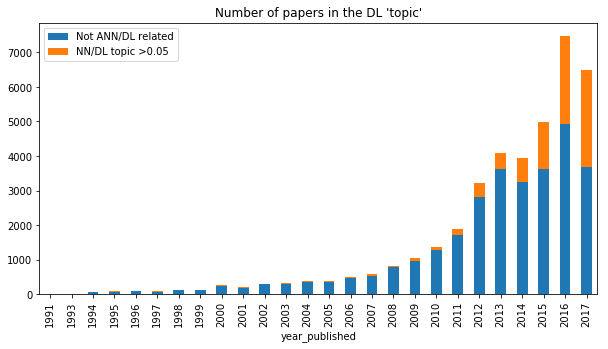

In [86]:
#Quick test of Deep learning papers

#These are papers with a topic that seems to capture deep learning
dl_papers = [x>0.05 for x in paper_topics_df['network_training_model_deep_deep_learning']]

dl_papers_metadata = pd.concat([pd.Series(dl_papers),all_papers],axis=1)

paper_frequencies = pd.crosstab(dl_papers_metadata.year_published,dl_papers_metadata[0])

paper_frequencies.columns=['no_dl','dl']


fig,ax = plt.subplots(figsize=(10,5))

paper_frequencies.plot.bar(stacked=True,ax=ax)
ax.set_title('Number of papers in the DL \'topic\'')
ax.legend(labels=['Not ANN/DL related','NN/DL topic >0.05'])

Some of this is interesting. Doesn't seem to be picking up the policy related terms (safety, discrimination)

Next stages - focus on policy related terms. Can we look for papers in keyword dictionaries identified through the word embeddings?


## Obtain Google Scholar data

In [102]:
#How many authors are there in the data? Can we collect all their institutions from Google Scholar

paper_authors = pd.Series([x for el in all_papers['authors'] for x in el.split(", ")])

paper_authors_unique = paper_authors.drop_duplicates()

len(paper_authors_unique)

68083

We have 68,000 authors. It might take a while to get their data from Google Scholar

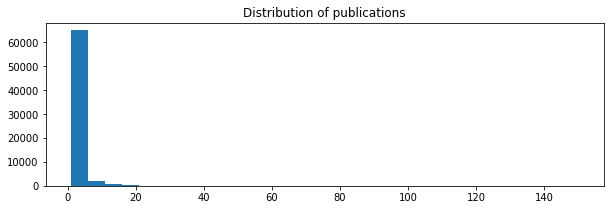

In [103]:
#Top authors and frequencies

authors_freq = paper_authors.value_counts()

fig,ax=plt.subplots(figsize=(10,3))

ax.hist(authors_freq,bins=30)
ax.set_title('Distribution of publications')

In [104]:
#Pretty skewed distribution!
print(authors_freq.describe())

np.sum(authors_freq>2)

count    68083.000000
mean         1.859701
std          2.795677
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        150.000000
dtype: float64


9856

Less than 10,000 authors with 3+ papers in the data

In [ ]:
get_scholar_data(

In [186]:
%%time
#Test run
import scholarly

@ratelim.patient(max_calls=30,time_interval=60)
def get_scholar_data(scholarly_object):
    ''''''    
    try:
        scholarly_object = next(scholarly_object)
        metadata = {}
        metadata['name']=scholarly_object.name
        metadata['affiliation'] = scholarly_object.affiliation
        metadata['interests'] = scholarly_object.interests
        return(metadata)
    
    except:
        return('nothing')
    

#Extract information from each query (it is a generator)
#Get data

#ml_author_gscholar=[]

for num,x in enumerate(paper_authors_unique[1484:]):
    if num % 100 == 0:
        print(str(num)+":"+x)    

    result = get_scholar_data(scholarly.search_author(x))
    ml_author_gscholar.append(result)

CPU times: user 178 µs, sys: 1e+03 ns, total: 179 µs
Wall time: 182 µs


In [182]:
len(ml_author_gscholar)

1484